In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits_cr import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_full_with_cr_7days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_with_cr_7days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_with_cr_7days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

290
287
388
452
324


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )

        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear((hidden_size*2) + 2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),

        )

    def forward(self, images, kp) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)
        image_features = image_features[:, -1, :]
        kp = kp.reshape(batch_size, 1)
        kp = kp.repeat(1, 2)
        image_features = torch.cat((image_features, kp), dim=1)
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels, p_Kp) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()

              # Forward pass with autograd
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels, p_Kp in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  p_Kp = p_Kp.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images, p_Kp).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              p_Kp = p_Kp.float()
              # print("Label: ", labels)
              outputs = model(images, p_Kp).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.493463802667773


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8242463584668478


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.9049791385296622


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9298739405649212


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.602294661486357


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.350696774672264


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2403985733439475


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.7617915241602886


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8947943156592523


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.908290603461901


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7231789855895737


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  3.118589119331102


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.595457094779001


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.839600881770718


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5079987182655032


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.8294653478502645


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4180475619670982


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.6985782153297126


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.38011124298592514


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.906923694191204


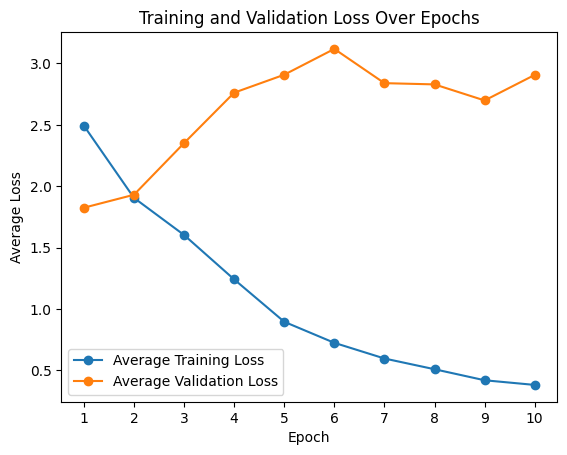

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.9069
RMSE: 1.7050
MSE: 2.9096
MAE: 1.3962
R²: -0.5523
R: 0.0167
True Skill Score: -0.1180
Accuracy: 0.5552
Precision: 0.2513
Recall: 0.3448
F1 Score: 0.2907


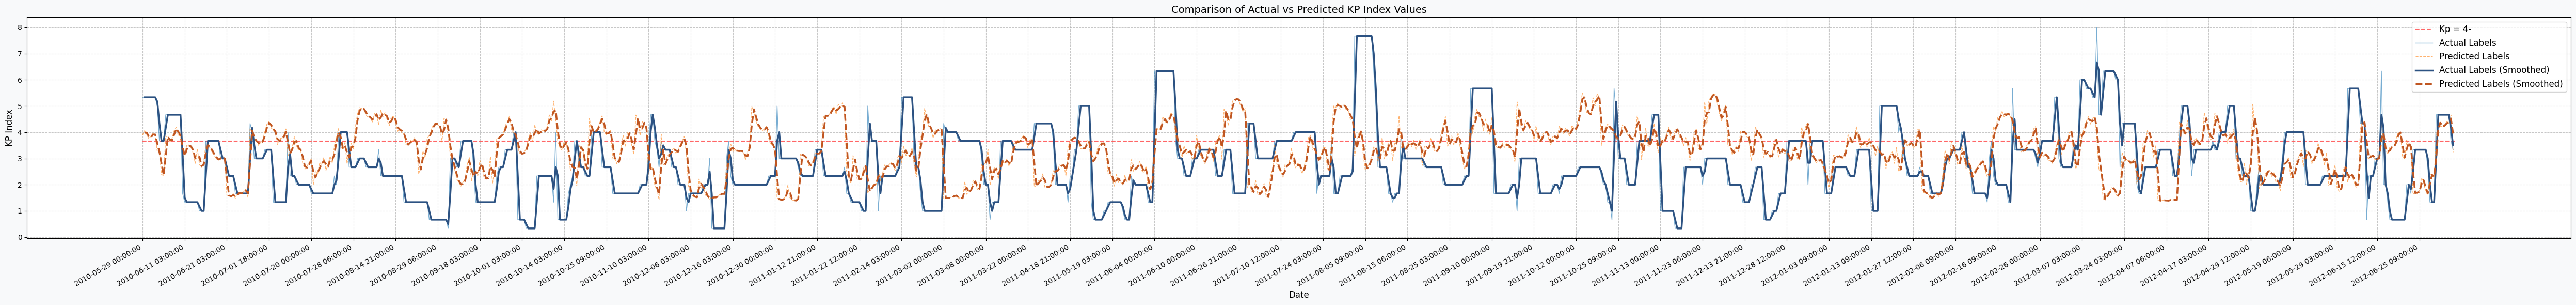

[np.float32(3.890625), np.float32(4.0625), np.float32(3.90625), np.float32(3.75), np.float32(3.859375), np.float32(3.96875), np.float32(3.859375), np.float32(3.265625), np.float32(3.234375), np.float32(2.390625), np.float32(2.34375), np.float32(3.859375), np.float32(3.796875), np.float32(3.625), np.float32(3.765625), np.float32(4.0625), np.float32(4.1875), np.float32(3.84375), np.float32(3.90625), np.float32(3.0), np.float32(3.203125), np.float32(3.5), np.float32(3.484375), np.float32(3.4375), np.float32(3.203125), np.float32(2.8125), np.float32(3.359375), np.float32(2.765625), np.float32(2.65625), np.float32(2.859375), np.float32(3.515625), np.float32(3.5), np.float32(3.40625), np.float32(3.234375), np.float32(3.125), np.float32(2.984375), np.float32(2.9375), np.float32(3.046875), np.float32(3.03125), np.float32(2.953125), np.float32(1.6015625), np.float32(1.578125), np.float32(1.546875), np.float32(1.65625), np.float32(1.4765625), np.float32(1.7265625), np.float32(1.65625), np.float3

Testing Progress:   0%|          | 0/145 [00:00<?, ?it/s]

Average test loss: 3.3352
RMSE: 1.8263
MSE: 3.3352
MAE: 1.4517
R²: -2.2491
R: 0.2377
True Skill Score: 0.0000
Accuracy: 0.3448
Precision: 1.0000
Recall: 0.3448
F1 Score: 0.5128


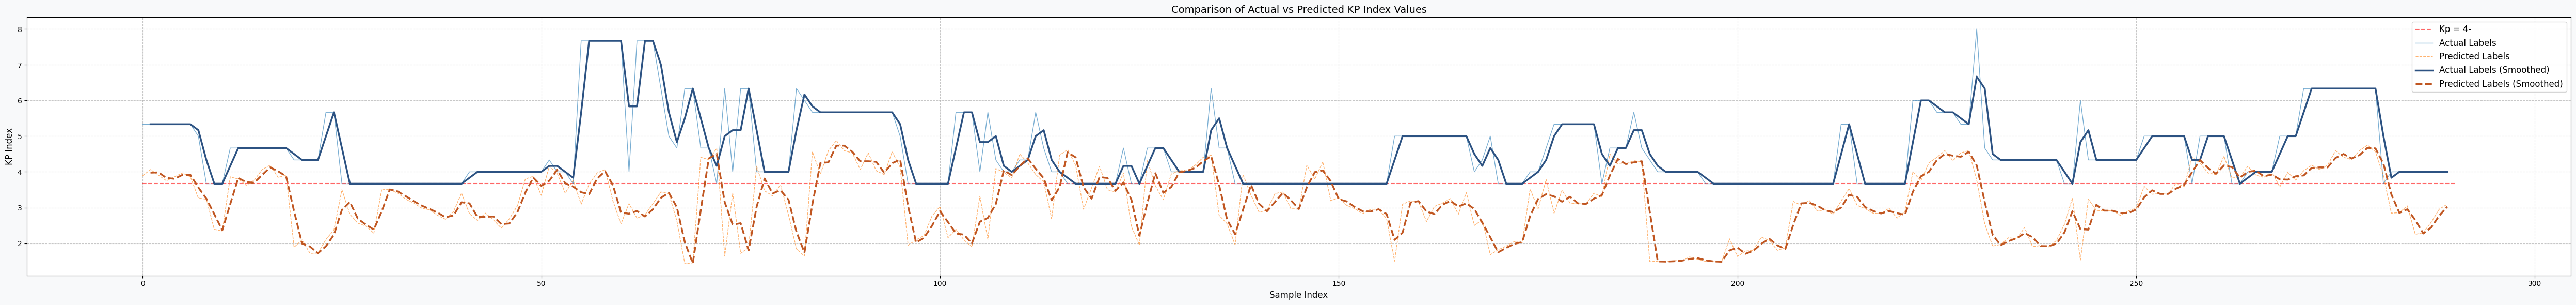

[np.float32(3.890625), np.float32(4.0625), np.float32(3.90625), np.float32(3.75), np.float32(3.859375), np.float32(3.96875), np.float32(3.859375), np.float32(3.265625), np.float32(3.234375), np.float32(2.390625), np.float32(2.34375), np.float32(3.859375), np.float32(3.796875), np.float32(3.625), np.float32(3.765625), np.float32(4.0625), np.float32(4.1875), np.float32(3.84375), np.float32(3.90625), np.float32(1.890625), np.float32(2.09375), np.float32(1.71875), np.float32(1.7265625), np.float32(2.109375), np.float32(2.375), np.float32(3.5), np.float32(2.8125), np.float32(2.5625), np.float32(2.484375), np.float32(2.28125), np.float32(3.515625), np.float32(3.5), np.float32(3.40625), np.float32(3.234375), np.float32(3.125), np.float32(2.984375), np.float32(2.9375), np.float32(2.78125), np.float32(2.671875), np.float32(2.890625), np.float32(3.40625), np.float32(2.828125), np.float32(2.640625), np.float32(2.84375), np.float32(2.65625), np.float32(2.421875), np.float32(2.6875), np.float32(3.0

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.4574752606291375


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2930902738994807


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8569175158256208


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0978864492930924


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5587007952543805


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4295754861875434


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1881469929198085


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.412858018609314


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.893631049970288


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.198736983962537


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6701633508395269


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.181212511119723


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5213535024600866


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.131094514379169


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4366435645598969


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.275004040672563


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.39166255959594776


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.335012924619306


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3402496310891552


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.196004756740744


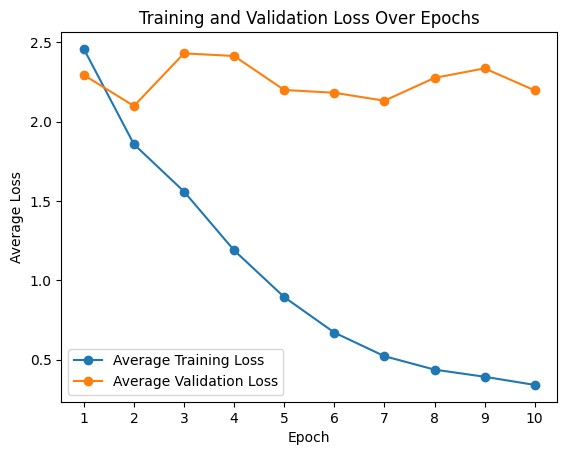

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1960
RMSE: 1.4819
MSE: 2.1979
MAE: 1.2044
R²: -0.0733
R: 0.1333
True Skill Score: 0.2302
Accuracy: 0.7138
Precision: 0.2857
Recall: 0.0627
F1 Score: 0.1029


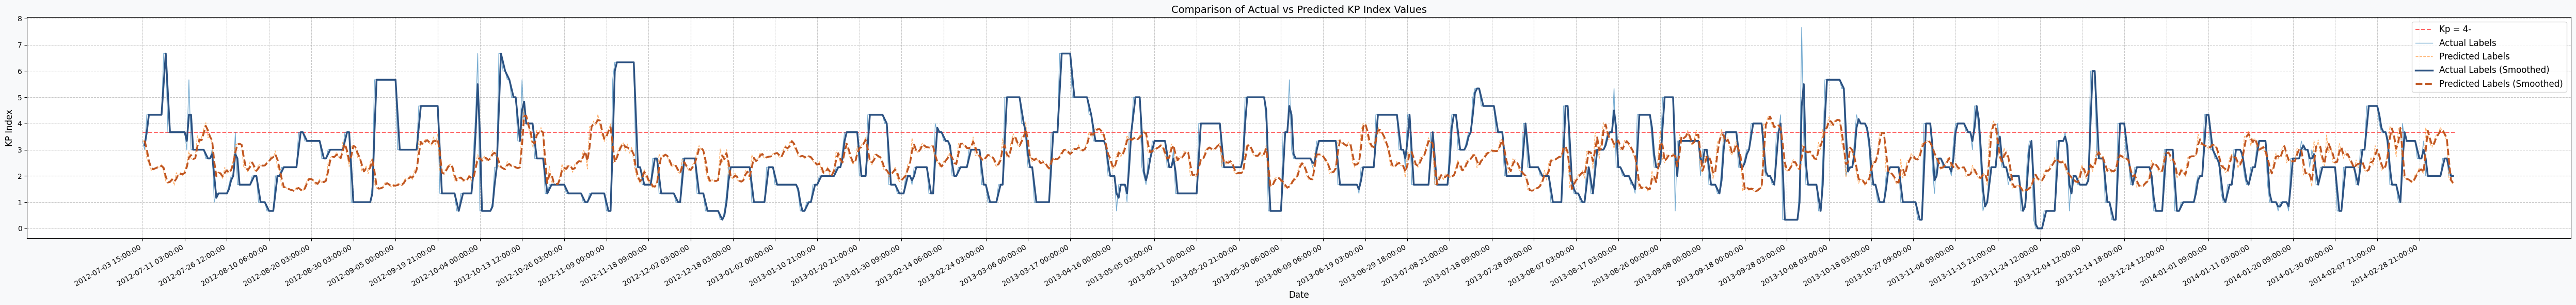

[np.float32(3.296875), np.float32(3.375), np.float32(2.671875), np.float32(2.46875), np.float32(2.203125), np.float32(2.296875), np.float32(2.28125), np.float32(2.359375), np.float32(2.3125), np.float32(2.453125), np.float32(2.171875), np.float32(1.7890625), np.float32(1.71875), np.float32(1.8203125), np.float32(1.90625), np.float32(1.6484375), np.float32(2.125), np.float32(2.015625), np.float32(2.125), np.float32(2.015625), np.float32(2.203125), np.float32(2.484375), np.float32(2.921875), np.float32(2.671875), np.float32(2.625), np.float32(2.71875), np.float32(3.53125), np.float32(3.25), np.float32(3.46875), np.float32(3.78125), np.float32(4.03125), np.float32(3.453125), np.float32(3.53125), np.float32(3.1875), np.float32(1.90625), np.float32(2.0625), np.float32(2.15625), np.float32(2.046875), np.float32(1.90625), np.float32(2.328125), np.float32(2.109375), np.float32(2.125), np.float32(2.3125), np.float32(2.59375), np.float32(3.1875), np.float32(3.21875), np.float32(3.234375), np.flo

Testing Progress:   0%|          | 0/144 [00:00<?, ?it/s]

Average test loss: 4.6198
RMSE: 2.1494
MSE: 4.5895
MAE: 1.8857
R²: -5.2285
R: 0.0882
True Skill Score: 0.0000
Accuracy: 0.0627
Precision: 1.0000
Recall: 0.0627
F1 Score: 0.1180


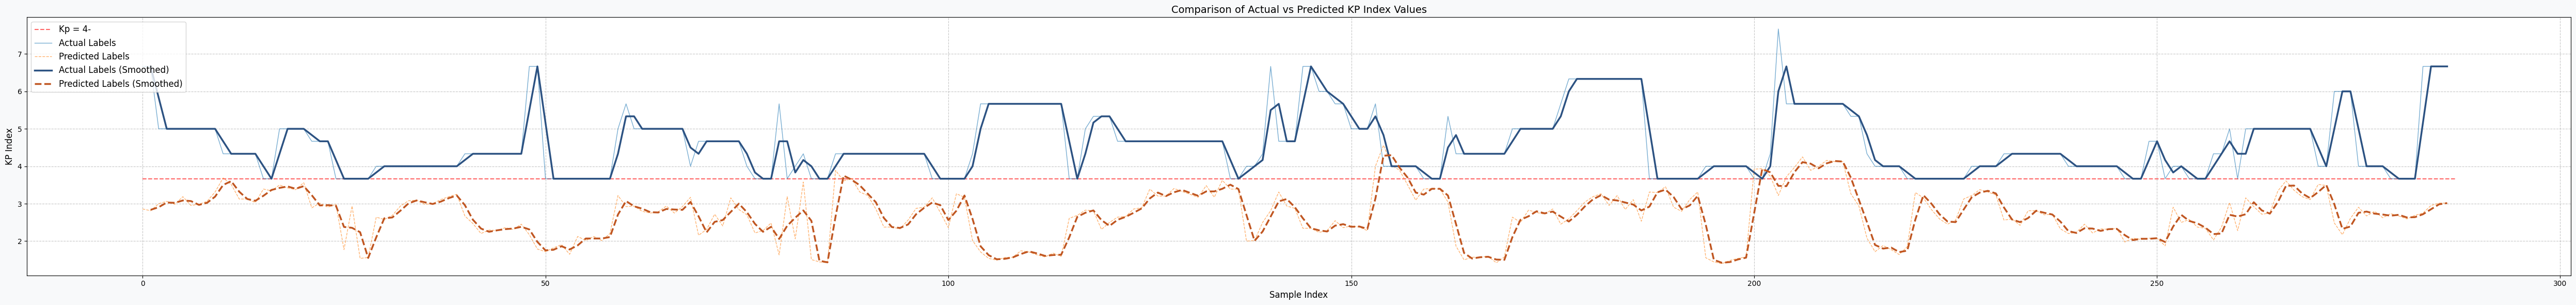

[np.float32(2.859375), np.float32(2.8125), np.float32(3.0), np.float32(3.0625), np.float32(2.984375), np.float32(3.1875), np.float32(2.953125), np.float32(2.984375), np.float32(3.0625), np.float32(3.3125), np.float32(3.6875), np.float32(3.515625), np.float32(3.125), np.float32(3.125), np.float32(3.03125), np.float32(3.390625), np.float32(3.34375), np.float32(3.5), np.float32(3.421875), np.float32(3.375), np.float32(3.5625), np.float32(2.890625), np.float32(3.015625), np.float32(2.90625), np.float32(2.984375), np.float32(1.7734375), np.float32(2.9375), np.float32(1.5390625), np.float32(1.5625), np.float32(2.640625), np.float32(2.578125), np.float32(2.6875), np.float32(2.9375), np.float32(3.078125), np.float32(3.09375), np.float32(2.984375), np.float32(3.0), np.float32(3.109375), np.float32(3.1875), np.float32(3.25), np.float32(2.671875), np.float32(2.46875), np.float32(2.203125), np.float32(2.296875), np.float32(2.28125), np.float32(2.359375), np.float32(2.3125), np.float32(2.453125), n

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.373253413641418


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3686931274598386


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.9809726345492844


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.941851167651971


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7284969013354026


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1599377032634783


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3646306306601592


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.384676414348511


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.98784493790984


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.629896743174207


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7370506516404006


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3387492248167807


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5895368252576988


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5281632442322293


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4941290887901379


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3975228976697642


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4006162551499915


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.736081721131581


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.35310391922012513


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.477567323460731


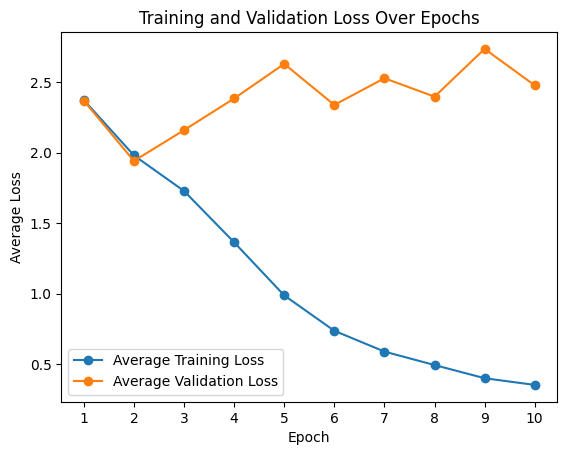

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.4776
RMSE: 1.5740
MSE: 2.4796
MAE: 1.2315
R²: -0.2704
R: 0.0765
True Skill Score: 0.2323
Accuracy: 0.6108
Precision: 0.4058
Recall: 0.2165
F1 Score: 0.2824


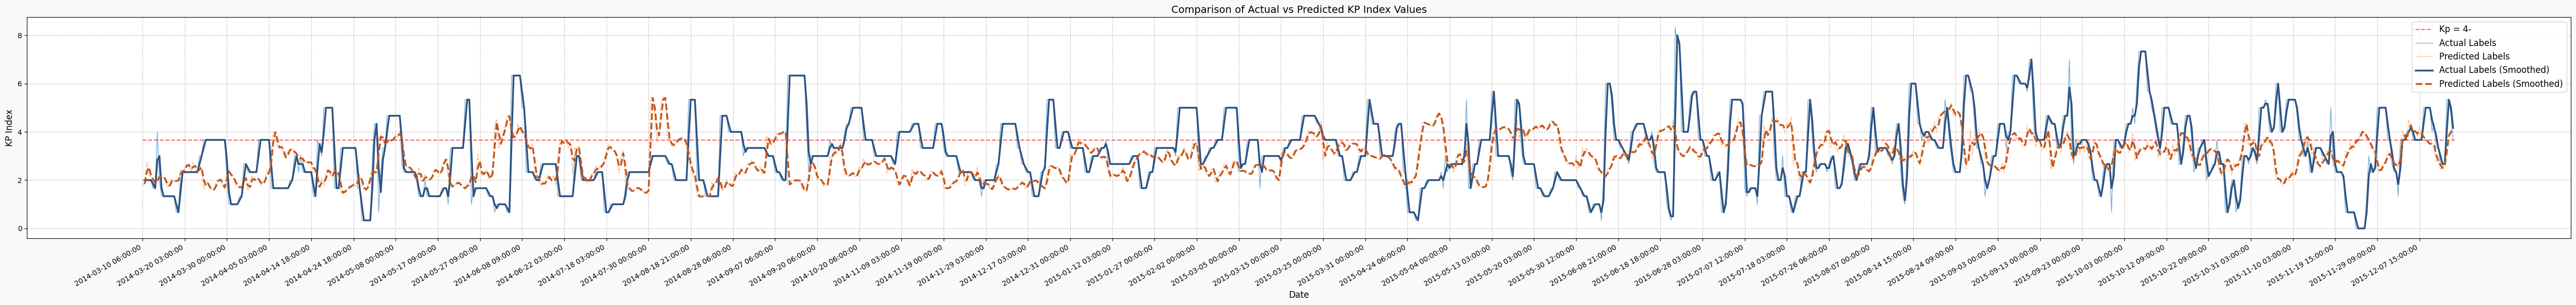

[np.float32(1.7578125), np.float32(1.9140625), np.float32(2.75), np.float32(2.3125), np.float32(2.109375), np.float32(1.96875), np.float32(1.765625), np.float32(2.171875), np.float32(2.078125), np.float32(2.171875), np.float32(2.125), np.float32(1.890625), np.float32(1.6875), np.float32(1.875), np.float32(2.0625), np.float32(1.9296875), np.float32(1.984375), np.float32(2.0), np.float32(2.453125), np.float32(2.296875), np.float32(2.5), np.float32(2.6875), np.float32(2.578125), np.float32(2.359375), np.float32(2.71875), np.float32(2.46875), np.float32(2.25), np.float32(2.609375), np.float32(2.453125), np.float32(1.6171875), np.float32(1.9296875), np.float32(1.8203125), np.float32(1.609375), np.float32(1.609375), np.float32(1.6171875), np.float32(1.9453125), np.float32(2.015625), np.float32(2.03125), np.float32(1.7578125), np.float32(1.6328125), np.float32(2.453125), np.float32(2.28125), np.float32(2.1875), np.float32(2.09375), np.float32(1.8359375), np.float32(1.7265625), np.float32(1.68

Testing Progress:   0%|          | 0/194 [00:00<?, ?it/s]

Average test loss: 4.0065
RMSE: 2.0016
MSE: 4.0065
MAE: 1.6973
R²: -3.8126
R: 0.1362
True Skill Score: 0.0000
Accuracy: 0.2165
Precision: 1.0000
Recall: 0.2165
F1 Score: 0.3559


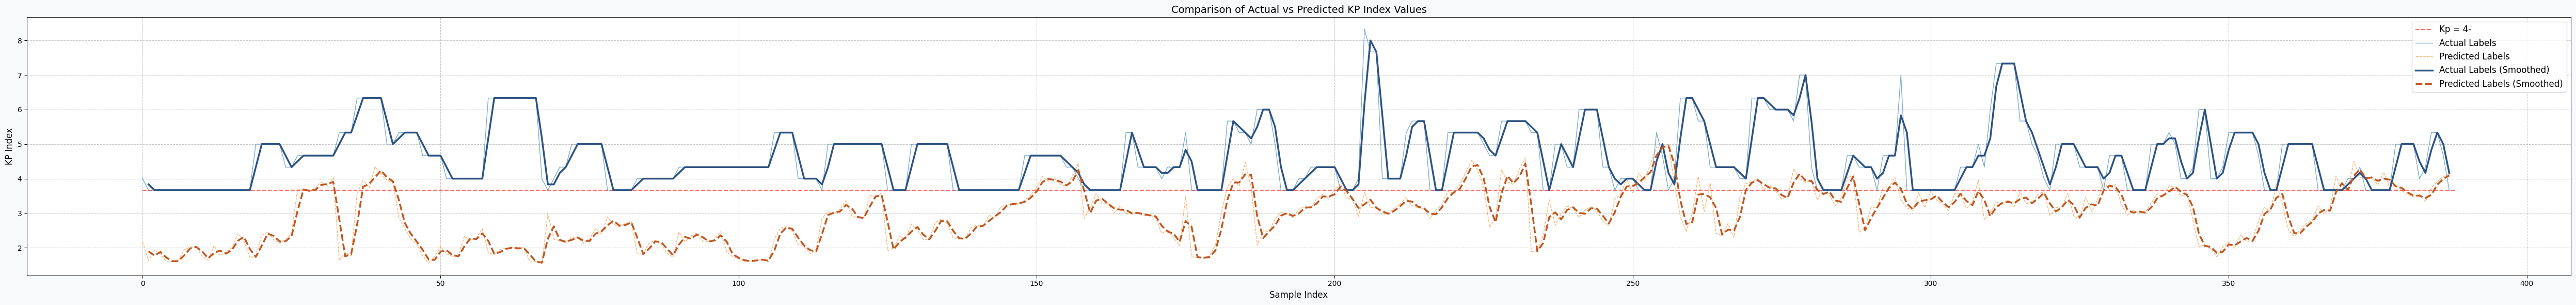

[np.float32(2.171875), np.float32(1.6171875), np.float32(1.9296875), np.float32(1.8203125), np.float32(1.609375), np.float32(1.609375), np.float32(1.6171875), np.float32(1.9453125), np.float32(2.015625), np.float32(2.03125), np.float32(1.7578125), np.float32(1.6328125), np.float32(2.0625), np.float32(1.7734375), np.float32(1.8828125), np.float32(2.0), np.float32(2.40625), np.float32(2.21875), np.float32(1.7109375), np.float32(1.7578125), np.float32(2.359375), np.float32(2.453125), np.float32(2.234375), np.float32(2.125), np.float32(2.25), np.float32(2.421875), np.float32(3.703125), np.float32(3.671875), np.float32(3.625), np.float32(3.734375), np.float32(3.90625), np.float32(3.78125), np.float32(4.03125), np.float32(1.6328125), np.float32(1.8671875), np.float32(1.765625), np.float32(3.578125), np.float32(3.953125), np.float32(3.734375), np.float32(4.34375), np.float32(4.125), np.float32(3.953125), np.float32(3.890625), np.float32(2.875), np.float32(2.5625), np.float32(2.25), np.float32

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.465765831585611


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.010042629005788


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.9831602724161137


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.347730643392782


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.8007488966503675


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9087799481045835


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5255973314839906


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.032058003137269


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.14219928961165


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0465798121724337


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8432171047152183


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.249633474983875


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6714125071952155


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.517976506036221


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5409659408541647


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2679966897352766


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.446200218158249


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.253590746825236


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3789134633792607


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.504084103833007


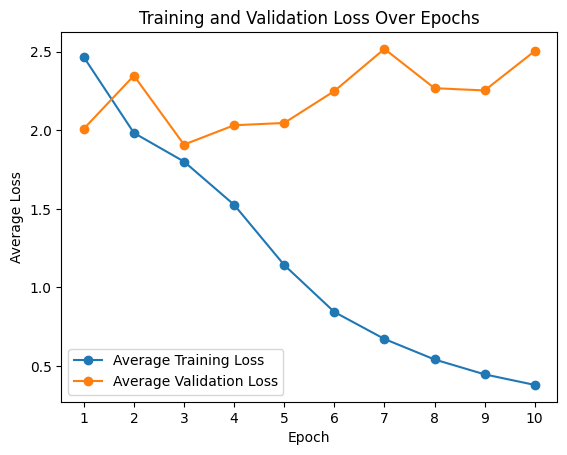

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.5041
RMSE: 1.5824
MSE: 2.5059
MAE: 1.2320
R²: -0.3458
R: 0.2158
True Skill Score: 0.4904
Accuracy: 0.6144
Precision: 0.5912
Recall: 0.2080
F1 Score: 0.3077


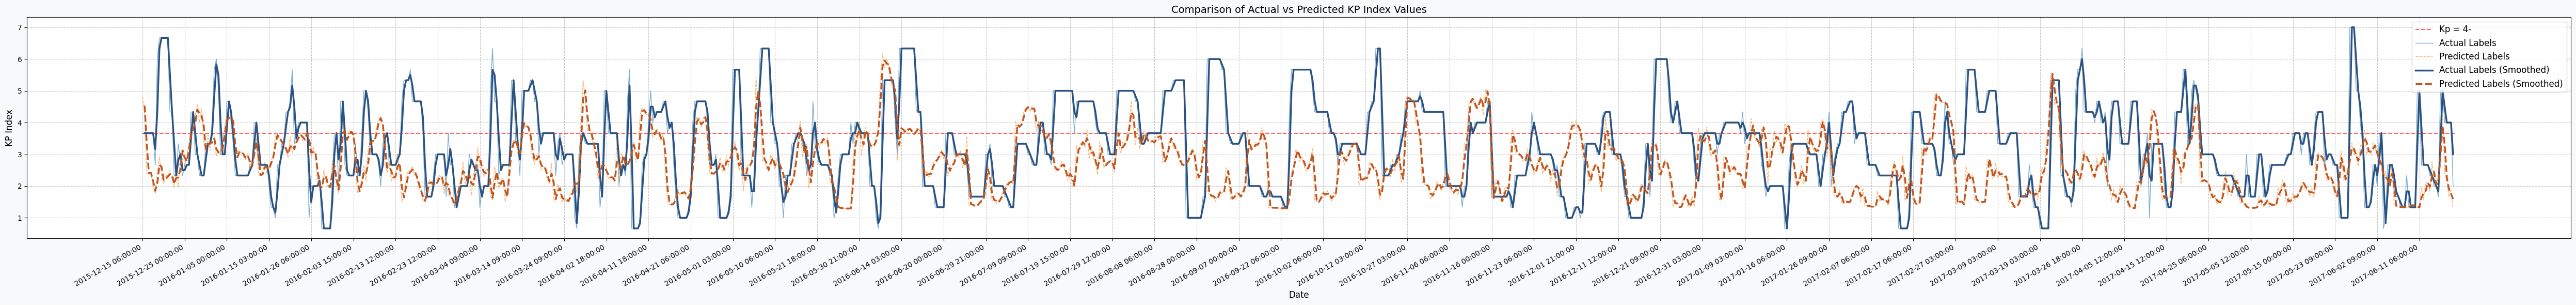

[np.float32(4.8125), np.float32(4.25), np.float32(2.390625), np.float32(2.4375), np.float32(2.390625), np.float32(1.9453125), np.float32(1.7578125), np.float32(2.421875), np.float32(2.90625), np.float32(2.3125), np.float32(2.078125), np.float32(2.359375), np.float32(2.25), np.float32(2.5), np.float32(2.203125), np.float32(1.9453125), np.float32(2.578125), np.float32(1.9765625), np.float32(3.09375), np.float32(3.140625), np.float32(2.65625), np.float32(2.90625), np.float32(3.34375), np.float32(3.859375), np.float32(3.75), np.float32(4.21875), np.float32(4.59375), np.float32(4.0), np.float32(4.4375), np.float32(3.390625), np.float32(2.96875), np.float32(3.609375), np.float32(3.125), np.float32(3.609375), np.float32(3.390625), np.float32(2.953125), np.float32(3.15625), np.float32(3.0), np.float32(3.34375), np.float32(3.90625), np.float32(4.21875), np.float32(4.09375), np.float32(4.1875), np.float32(3.921875), np.float32(2.6875), np.float32(3.125), np.float32(3.03125), np.float32(3.09375),

Testing Progress:   0%|          | 0/226 [00:00<?, ?it/s]

Average test loss: 4.4589
RMSE: 2.1116
MSE: 4.4589
MAE: 1.8033
R²: -5.6323
R: 0.1000
True Skill Score: 0.0000
Accuracy: 0.2080
Precision: 1.0000
Recall: 0.2080
F1 Score: 0.3443


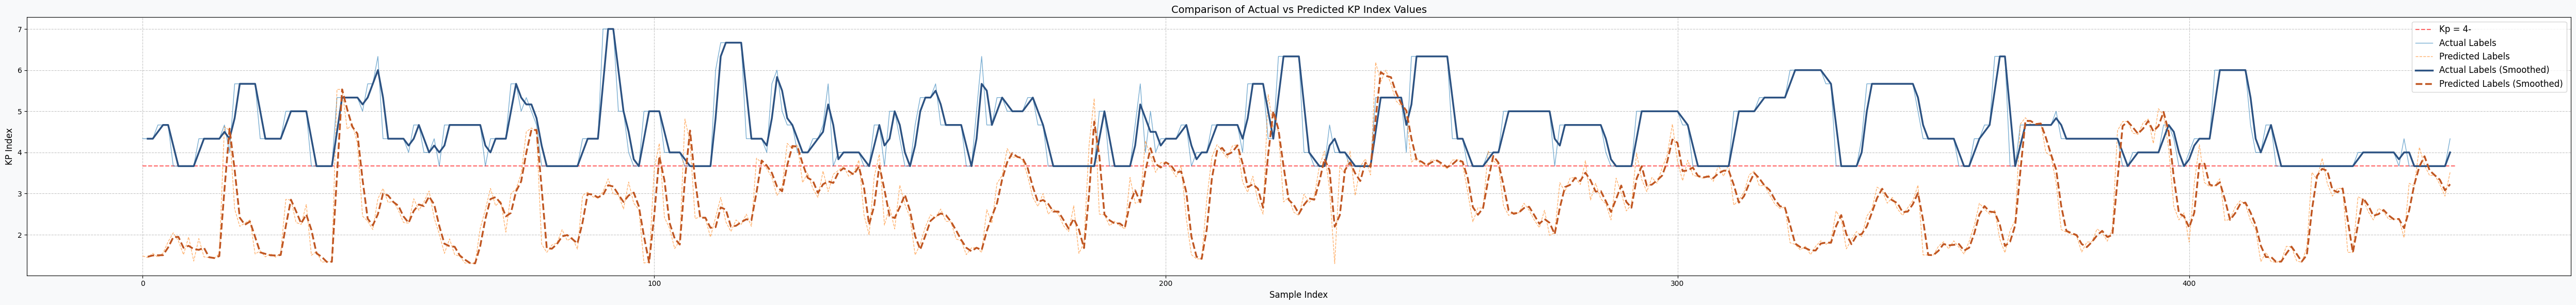

[np.float32(1.484375), np.float32(1.4453125), np.float32(1.546875), np.float32(1.453125), np.float32(1.5546875), np.float32(1.828125), np.float32(2.046875), np.float32(1.8515625), np.float32(1.515625), np.float32(1.9453125), np.float32(1.359375), np.float32(1.90625), np.float32(1.4609375), np.float32(1.4453125), np.float32(1.421875), np.float32(1.5390625), np.float32(4.625), np.float32(4.53125), np.float32(2.625), np.float32(2.203125), np.float32(2.28125), np.float32(2.359375), np.float32(1.53125), np.float32(1.609375), np.float32(1.4609375), np.float32(1.5390625), np.float32(1.453125), np.float32(1.5625), np.float32(2.859375), np.float32(2.84375), np.float32(2.296875), np.float32(2.25), np.float32(2.734375), np.float32(1.5), np.float32(1.59375), np.float32(1.3359375), np.float32(1.34375), np.float32(1.34375), np.float32(5.53125), np.float32(5.53125), np.float32(4.5625), np.float32(4.6875), np.float32(4.21875), np.float32(2.453125), np.float32(2.328125), np.float32(2.125), np.float32(2

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.4601559887977698


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.8825833024626428


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.8816702186041694


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.9557940991522693


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.5058151330872778


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  3.1297518638709816


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.08333834838189


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.4826591924615125


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.7948993472538441


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  3.242116458882493


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.6443983570309848


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.3116433872731235


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5027106413182101


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.4773225216897714


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.42635685469531176


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.2227797468105033


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3704132935906282


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.4514537797618488


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3326311174264194


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.26207139425403


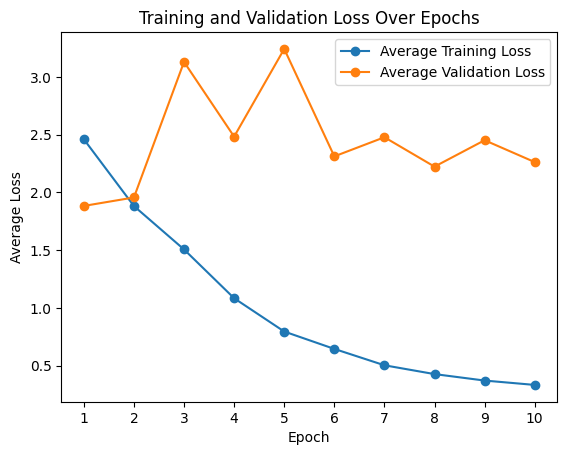

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 2.2621
RMSE: 1.5040
MSE: 2.2596
MAE: 1.2157
R²: -0.1797
R: 0.1206
True Skill Score: 0.1378
Accuracy: 0.6388
Precision: 0.3069
Recall: 0.1790
F1 Score: 0.2261


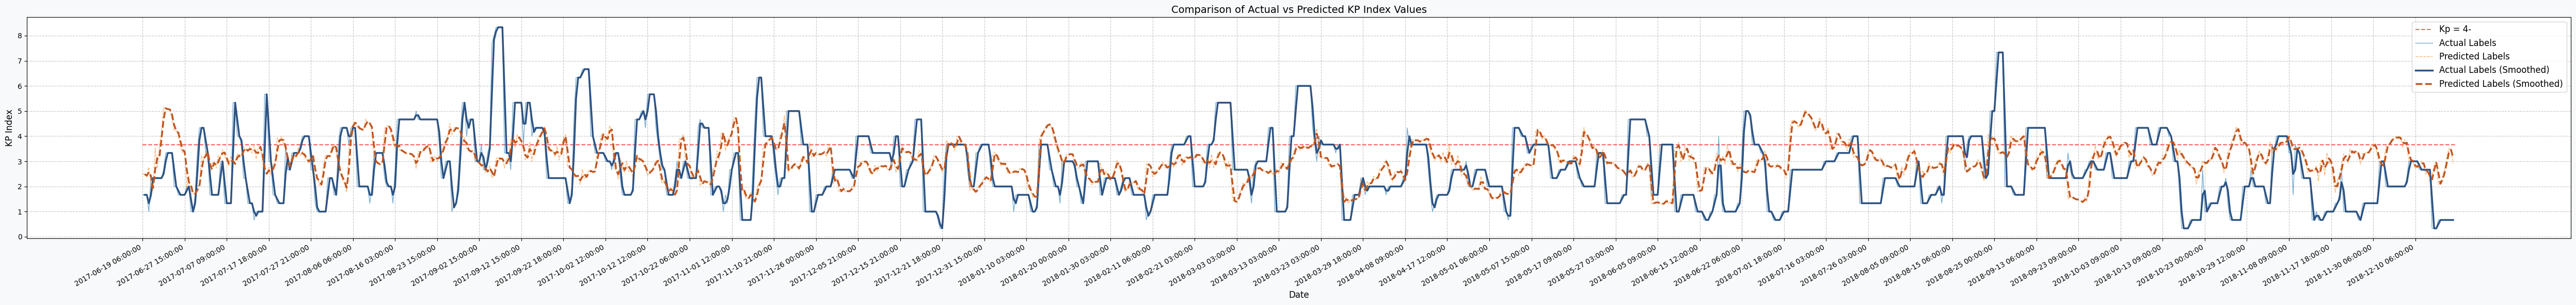

[np.float32(2.515625), np.float32(2.46875), np.float32(2.390625), np.float32(2.765625), np.float32(2.0625), np.float32(1.828125), np.float32(3.53125), np.float32(2.71875), np.float32(3.59375), np.float32(4.1875), np.float32(5.15625), np.float32(5.0625), np.float32(5.09375), np.float32(5.03125), np.float32(4.6875), np.float32(4.21875), np.float32(4.21875), np.float32(4.0625), np.float32(3.5625), np.float32(3.34375), np.float32(3.4375), np.float32(1.9296875), np.float32(2.421875), np.float32(1.6875), np.float32(1.75), np.float32(1.671875), np.float32(2.03125), np.float32(1.9921875), np.float32(3.234375), np.float32(3.015625), np.float32(3.390625), np.float32(3.375), np.float32(2.4375), np.float32(2.921875), np.float32(2.953125), np.float32(2.734375), np.float32(3.21875), np.float32(3.171875), np.float32(3.46875), np.float32(3.234375), np.float32(3.03125), np.float32(2.796875), np.float32(3.21875), np.float32(2.8125), np.float32(2.984375), np.float32(3.3125), np.float32(3.15625), np.float

Testing Progress:   0%|          | 0/162 [00:00<?, ?it/s]

Average test loss: 3.1556
RMSE: 1.7764
MSE: 3.1556
MAE: 1.4060
R²: -2.6800
R: -0.0975
True Skill Score: 0.0000
Accuracy: 0.1790
Precision: 1.0000
Recall: 0.1790
F1 Score: 0.3037


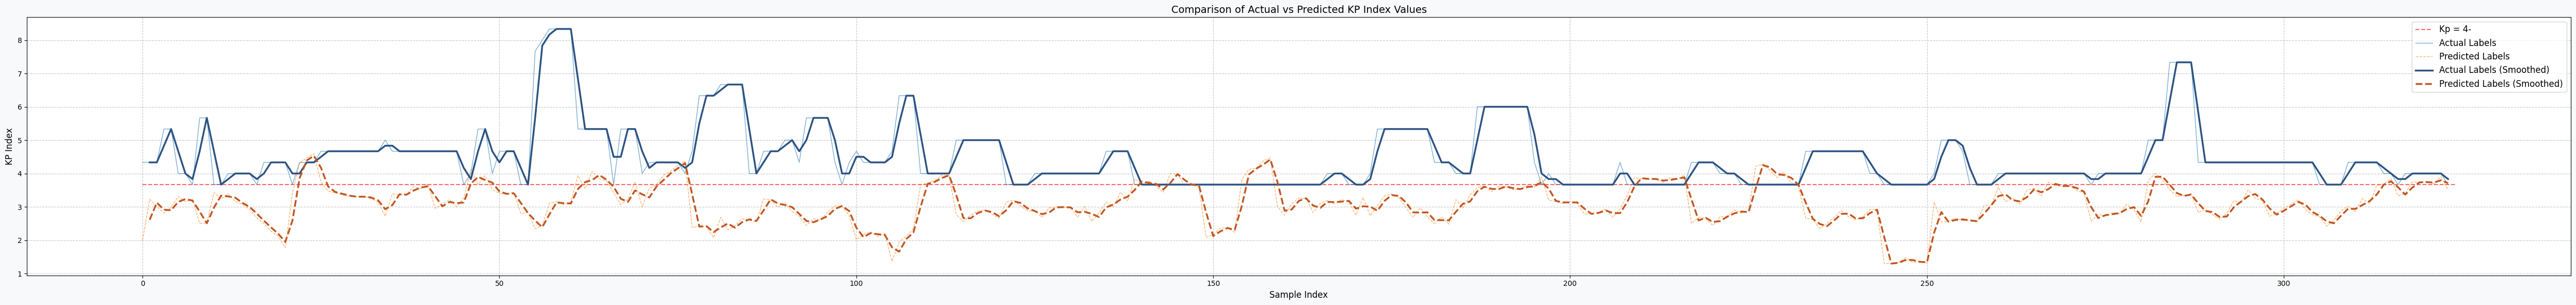

[np.float32(1.9921875), np.float32(3.234375), np.float32(3.015625), np.float32(2.8125), np.float32(2.984375), np.float32(3.3125), np.float32(3.15625), np.float32(3.21875), np.float32(2.5), np.float32(2.515625), np.float32(3.4375), np.float32(3.234375), np.float32(3.390625), np.float32(3.15625), np.float32(3.078125), np.float32(2.921875), np.float32(2.671875), np.float32(2.5), np.float32(2.265625), np.float32(2.125), np.float32(1.7734375), np.float32(3.40625), np.float32(4.3125), np.float32(4.46875), np.float32(4.59375), np.float32(3.75), np.float32(3.46875), np.float32(3.421875), np.float32(3.359375), np.float32(3.3125), np.float32(3.296875), np.float32(3.3125), np.float32(3.25), np.float32(3.140625), np.float32(2.71875), np.float32(3.390625), np.float32(3.359375), np.float32(3.375), np.float32(3.609375), np.float32(3.546875), np.float32(3.6875), np.float32(2.953125), np.float32(3.078125), np.float32(3.21875), np.float32(3.0), np.float32(3.265625), np.float32(4.125), np.float32(3.67187

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)


In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
